#  Размещение баннеров

## Машинное обучение и анализ данных
### 3 курс, 1 неделя

Задание
 Представим, что международное круизное агентство Carnival Cruise Line решило себя разрекламировать с помощью баннеров и обратилось для этого к вам. Чтобы протестировать, велика ли от таких баннеров польза, их будет размещено всего 20 штук по всему миру. Вам надо выбрать 20 таких локаций для размещения, чтобы польза была большой и агентство продолжило с вами сотрудничать.

Агентство крупное, и у него есть несколько офисов по всему миру. Вблизи этих офисов оно и хочет разместить баннеры — легче договариваться и проверять результат. Также эти места должны быть популярны среди туристов.

Для поиска оптимальных мест воспользуемся базой данных крупнейшей социальной сети, основанной на локациях — Foursquare.

Часть открытых данных есть, например, на сайте archive.org:

https://archive.org/details/201309_foursquare_dataset_umn

Скачаем любым удобным образом архив fsq.zip с этой страницы.

Нас будет интересовать файл checkins.dat. Открыв его, увидим следующую структуру:


1
2
3
4
5
6
7
8
9
10
11
12
13
id | user_id | venue_id | latitude | longitude | created_at
---------+---------+----------+-------------------+-------------------+-----
----------------
984301 | 2041916 | 5222 | | | 2012-04-21 17:39:01
984222 | 15824 | 5222 | 38.8951118 | -77.0363658 | 2012-04-21 17:43:47
984315 | 1764391 | 5222 | | | 2012-04-21 17:37:18
984234 | 44652 | 5222 | 33.800745 | -84.41052 | 2012-04-21 17:43:43
...
Для удобной работы с этим документом преобразуем его к формату csv, удалив строки, не содержащие координат — они неинформативны для нас:


1
2
3
4
5
6
7
8
9
id,user_id,venue_id,latitude,longitude,created_at
984222,15824,5222,38.8951118,-77.0363658,2012-04-21T17:43:47
984234,44652,5222,33.800745,-84.41052,2012-04-21T17:43:43
984291,105054,5222,45.5234515,-122.6762071,2012-04-21T17:39:22
...
С помощью pandas построим DataFrame и убедимся, что все 396634 строки с координатами считаны успешно.

Теперь необходимо кластеризовать данные координаты, чтобы выявить центры скоплений туристов. Поскольку баннеры имеют сравнительно небольшую площадь действия, нам нужен алгоритм, позволяющий ограничить размер кластера и не зависящий от количества кластеров.

Эта задача — хороший повод познакомиться с алгоритмом MeanShift, который мы обошли стороной в основной части лекций. Его описание при желании можно посмотреть в sklearn user guide, а чуть позже появится дополнительное видео с обзором этого и некоторых других алгоритмов кластеризации. Используйте MeanShift, указав bandwidth=0.1, что в переводе из градусов в метры колеблется примерно от 5 до 10 км в средних широтах.

Примечание: на 396634 строках кластеризация будет работать долго. Быть очень терпеливым не возбраняется — результат от этого только улучшится. Но для того, чтобы сдать задание, понадобится сабсет из первых 100 тысяч строк. Это компромисс между качеством и затраченным временем. Обучение алгоритма на всём датасете занимает около часа, а на 100 тыс. строк — примерно 2 минуты, однако этого достаточно для получения корректных результатов.

Некоторые из получившихся кластеров содержат слишком мало точек — такие кластеры не интересны рекламодателям. Поэтому надо определить, какие из кластеров содержат, скажем, больше 15 элементов. Центры этих кластеров и являются оптимальными для размещения.

При желании увидеть получившиеся результаты на карте можно передать центры получившихся кластеров в один из инструментов визуализации. Например, сайт mapcustomizer.com имеет функцию Bulk Entry, куда можно вставить центры полученных кластеров в формате:


1
2
3
4
5
6
7
38.8951118,-77.0363658
33.800745,-84.41052
45.5234515,-122.6762071
...
Как мы помним, 20 баннеров надо разместить близ офисов компании. Найдем на Google Maps по запросу Carnival Cruise Line адреса всех офисов:


1
2
3
4
5
6
7
8
9
10
11
33.751277, -118.188740 (Los Angeles)
25.867736, -80.324116 (Miami)
51.503016, -0.075479 (London)
52.378894, 4.885084 (Amsterdam)
39.366487, 117.036146 (Beijing)
-33.868457, 151.205134 (Sydney)
Осталось определить 20 ближайших к ним центров кластеров. Т.е. посчитать дистанцию до ближайшего офиса для каждой точки и выбрать 20 с наименьшим значением.

Примечание: при подсчете расстояний и в кластеризации можно пренебречь тем, что Земля круглая, так как в точках, расположенных близко друг к другу погрешность мала, а в остальных точках значение достаточно велико.

Для сдачи задания выберите из получившихся 20 центров тот, который наименее удален от ближайшего к нему офиса. Ответ в этом задании — широта и долгота этого центра, записанные через пробел.



In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
import seaborn as sns
import matplotlib.pyplot as plt
import re
from numpy.linalg import norm

In [2]:
df = pd.read_csv('checkins.dat', delimiter='|', skiprows=[1])

/Applications/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021967 entries, 0 to 1021966
Data columns (total 6 columns):
   id                    1021967 non-null object
 user_id                 1021966 non-null float64
 venue_id                1021966 non-null float64
     latitude            1021966 non-null object
     longitude           1021966 non-null object
     created_at          1021966 non-null object
dtypes: float64(2), object(4)
memory usage: 46.8+ MB


In [4]:
# Deleting whitespaces
df = df.iloc[:,[3,4]].apply(lambda x: x.str.strip())

In [5]:
cols = ['Latitude','Longitude']
df.columns = ['Latitude','Longitude']

In [6]:
# Converting 'objects' to 'numeric' values with dropping NaN represented as whitespaces.
df = df[cols].apply(lambda x: pd.to_numeric(x, errors='coerce'))
df.dropna(inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 396634 entries, 1 to 1021964
Data columns (total 2 columns):
Latitude     396634 non-null float64
Longitude    396634 non-null float64
dtypes: float64(2)
memory usage: 9.1 MB


In [8]:
#cut off first 100,000 rows
N_ROWS = 100000
df = df.iloc[:N_ROWS,:]
La = df.loc[:,'Latitude'].values.reshape(N_ROWS,1)
Lo = df.loc[:,'Longitude'].values.reshape(N_ROWS,1)

/Applications/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: This function is deprecated. Please call randint(0, 100000 + 1) instead
  


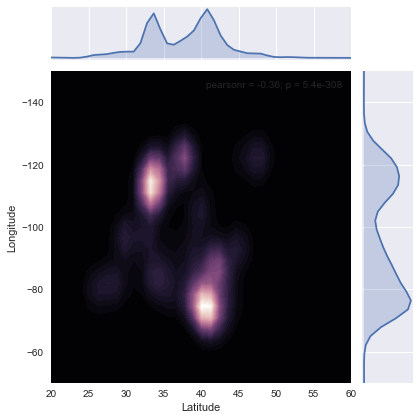

In [9]:
#Plot represents set of  ~1/10 of data points
random_IDXS = np.random.random_integers(0,df.shape[0], 10000)
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
jplot = sns.jointplot(cols[0], cols[1], df.iloc[random_IDXS,:], 
                     xlim=(20,60), ylim=(-50,-150), cmap = cmap, kind='kde', shade=True, n_levels=60)
plt.show()

In [10]:
X = np.array(df.loc[:,['Latitude','Longitude']])

In [11]:
%%time
estimator = MeanShift(bandwidth=0.1, n_jobs=(-1))
estimator.fit(X)

CPU times: user 40.8 s, sys: 3.08 s, total: 43.8 s
Wall time: 1min 53s


In [12]:
print 'Cluster centers: ', estimator.cluster_centers_.shape
df['cluster'] = estimator.labels_

Cluster centers:  (3230, 2)


In [13]:
count_cluster_freq = df.iloc[:,2].value_counts()

In [14]:
df['cluster_freq']      = [count_cluster_freq[cluster_ID]            for i, cluster_ID in enumerate(df['cluster'])]
df['cluster_cntr_lati'] = [estimator.cluster_centers_[cluster_ID][0] for i, cluster_ID in enumerate(df['cluster'])]
df['cluster_cntr_long'] = [estimator.cluster_centers_[cluster_ID][1] for i, cluster_ID in enumerate(df['cluster'])]
 
df = df[df.cluster_freq > 15]
df.head()

,Latitude,Longitude,cluster,cluster_freq,cluster_cntr_lati,cluster_cntr_long
1,38.895112,-77.036366,5,2409,38.886165,-77.048783
3,33.800745,-84.410520,7,1601,33.766636,-84.393289
7,45.523452,-122.676207,30,594,45.523483,-122.676280
9,40.764462,-111.904565,66,186,40.759600,-111.896078
10,33.448377,-112.074037,1,4692,33.449438,-112.002140


## Carnival Cruise Line offices:
33.751277, -118.188740,Los Angeles

25.867736, -80.324116,Miami

51.503016, -0.075479,London

52.378894, 4.885084,Amsterdam

39.366487, 117.036146,Beijing

-33.868457, 151.205134,Sydney

In [15]:
# Create dictionary with coordinates of the offices from clipboard:
#df_offices = pd.read_clipboard(names = ['Latitude', 'Longitude', 'City'], delimiter = (','))
#df_offices.to_csv('df_offices.csv')

In [16]:
df_offices = pd.read_csv('df_offices.csv')

In [17]:
df_offices.drop(['Unnamed: 0'], axis=1, inplace=True)
df_offices.set_index("City", inplace=True)
df_offices

,Latitude,Longitude
City,,
Los Angeles,33.751277,-118.188740
Miami,25.867736,-80.324116
London,51.503016,-0.075479
Amsterdam,52.378894,4.885084
Beijing,39.366487,117.036146
Sydney,-33.868457,151.205134


In [38]:
city_LaLo = np.array([np.array([df_offices.loc[city, 'Latitude'],df_offices.loc[city, 'Longitude']]) for _,city in enumerate(df_offices.index)])
clst_LaLo = np.array([np.array([df.iloc[i, 4],df.iloc[i, 5]]) for i in xrange(len(df))])

In [44]:
for i,city in enumerate(df_offices.index):
    df['distance_{}'.format(city)] = np.array([norm(clst_LaLo[index] - city_LaLo[i], ord=2) for index in xrange(len(df))])

In [40]:
df.head()

,Latitude,Longitude,cluster,cluster_freq,cluster_cntr_lati,cluster_cntr_long,distance_Los Angeles,distance_Miami,distance_London,distance_Amsterdam,distance_Beijing,distance_Sydney
1,38.895112,-77.036366,5,2409,38.886165,-77.048783,41.459174,13.424131,78.000478,83.037415,194.085524,239.568541
3,33.800745,-84.410520,7,1601,33.766636,-84.393289,33.795454,8.885426,86.163056,91.197829,201.507260,245.114510
7,45.523452,-122.676207,30,594,45.523483,-122.676280,12.598526,46.691051,122.746533,127.745444,239.791484,285.156289
9,40.764462,-111.904565,66,186,40.759600,-111.896078,9.418821,34.907827,112.335512,117.357777,228.936462,273.480519
10,33.448377,-112.074037,1,4692,33.449438,-112.002140,6.193959,32.572679,113.373317,118.410081,229.114704,271.679532


In [49]:
norm(np.array([38.895112, -77.036366]) - np.array([33.751277, -118.18874]), ord=2)

41.472604503974672

In [50]:
norm(clst_LaLo[0] - city_LaLo[0], ord=2)

41.45917403585171

In [51]:
clst_LaLo[0]

array([ 38.88616522, -77.04878333])

In [52]:
city_LaLo[0]

array([  33.751277, -118.18874 ])

In [58]:
np.argmin(df[np.argmin(np.min(df.iloc[:, -6:]))])

782

In [62]:
df.loc[782, 'distance_Sydney']

0.0078347581631091553

In [60]:
np.argmin(np.min(df.iloc[:, -6:]))

'distance_Sydney'

In [61]:
np.min(df.iloc[:, -6:])

distance_Los Angeles    0.070848
distance_Miami          0.022674
distance_London         0.050058
distance_Amsterdam      0.009353
distance_Beijing        9.267575
distance_Sydney         0.007835
dtype: float64

In [63]:
def write_ans(ans, name):
    with open (name, 'w') as fout:
        fout.write(str(ans))
        fout.close

In [64]:
write_ans([df.loc[782, 'Latitude'], df.loc[782, 'Longitude']], 'ans.txt')